## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import collections
import shutil
import tempfile
import zipfile
from pathlib import Path
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.inference import InferenceDataset
from anomalib.models import get_model
from anomalib.models.patchcore.lightning_model import PatchcoreLightning
from anomalib.post_processing.post_process import compute_mask
from anomalib.utils.callbacks import get_callbacks
from anomalib.utils.loggers import get_experiment_logger
from pytorch_lightning import Trainer, seed_everything
from skimage.morphology import dilation
from skimage.segmentation import find_boundaries
from torch.utils.data import DataLoader

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


We use the IDRiD dataset which can be downloaded here: https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid
We only use part 'B. Disease Grading.zip' (as it's the only one that also includes labeled images of healthy retinas), download the ZIP file and put it in the data folder before you continue.

In [ ]:
DATA_FOLDER = Path("data")
IDRID_ZIP_LOCATION = DATA_FOLDER / "B. Disease Grading.zip"

PATCHCORE_CONFIG_PATH = "cfg/patchcore_config.yaml"
PATCHCORE_OUTPUT_DIR = Path("models")

## Data preparation

We copy all images of healthy retina to data_folder/idrid/normal, these will be used to train the model. We copy images with signs of diabetic retinopathy to data_folder/idrid/X where X indicates the severeness of diabetic retinopathy (from 1 to 4).

In [ ]:
with tempfile.TemporaryDirectory() as tmp_data_dir:
    with zipfile.ZipFile(IDRID_ZIP_LOCATION, "r") as idrid_zip_ref:
        idrid_zip_ref.extractall(tmp_data_dir)

        tmp_data_dir = Path(tmp_data_dir)
        gt_path = tmp_data_dir / "B. Disease Grading" / "2. Groundtruths"
        original_img_path = tmp_data_dir / "B. Disease Grading" / "1. Original Images"

        normal_img_dst = DATA_FOLDER / "idrid" / "normal"
        normal_img_dst.mkdir(exist_ok=True, parents=True)

        dr_img_dst = DATA_FOLDER / "idrid" / "dr"
        dr_img_dst.mkdir(exist_ok=True, parents=True)

        for csv_fn, dir_name in [
            ("a. IDRiD_Disease Grading_Training Labels.csv", "a. Training Set"),
            ("b. IDRiD_Disease Grading_Testing Labels.csv", "b. Testing Set"),
        ]:
            gt_csv = pd.read_csv(gt_path / csv_fn)

            no_retinopathy = gt_csv[gt_csv["Retinopathy grade"] == 0]
            for _, no_retinopathy_img in no_retinopathy.iterrows():
                shutil.copy(
                    original_img_path
                    / dir_name
                    / (no_retinopathy_img["Image name"] + ".jpg"),
                    normal_img_dst
                    / f"{dir_name.strip()}_{no_retinopathy_img['Image name']}.jpg",
                )

            for retinopathy_grade in range(1, 5):
                cur_dst = dr_img_dst / str(retinopathy_grade)
                cur_dst.mkdir(exist_ok=True, parents=True)

                retinopathy_subset = gt_csv[
                    gt_csv["Retinopathy grade"] == retinopathy_grade
                ]
                for _, retinopathy_img in retinopathy_subset.iterrows():
                    shutil.copy(
                        original_img_path
                        / dir_name
                        / (retinopathy_img["Image name"] + ".jpg"),
                        cur_dst
                        / f"{dir_name.strip()}_{retinopathy_img['Image name']}.jpg",
                    )

## Model training

In [ ]:
config = get_configurable_parameters(
    model_name="patchcore", config_path=PATCHCORE_CONFIG_PATH
)
if config.project.seed:
    seed_everything(config.project.seed)

datamodule = get_datamodule(config)
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/utils/callbacks/__init__.py:133: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")


In [ ]:
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

## Evaluate on some images showing signs of diabetic retinopathy

In [ ]:
def prepare_predictor(
    model_config_path: str, model_weight_path: str
) -> Tuple[PatchcoreLightning, Trainer]:
    """Load anomalib model"""
    pred_config = get_configurable_parameters(config_path=model_config_path)
    pred_config.trainer.resume_from_checkpoint = model_weight_path
    pred_config.visualization.show_images = False
    pred_config.visualization.save_images = False

    model = get_model(pred_config)
    pred_callbacks = get_callbacks(pred_config)

    pred_trainer = Trainer(callbacks=pred_callbacks, **pred_config.trainer)
    return model, pred_trainer


def get_prediction(
    img_path: str,
    model: PatchcoreLightning,
    pred_trainer: Trainer,
    img_size: Tuple[int, int] = (256, 256),
):
    """Get a prediction for an image at img_path by a model with given config"""

    dataset = InferenceDataset(
        img_path,
        image_size=img_size,
        transform_config=None,
    )
    dataloader = DataLoader(dataset)
    return pred_trainer.predict(model=model, dataloaders=[dataloader])


def add_segmentation_boundary(
    image: np.ndarray,
    anomaly_map: np.ndarray,
    threshold: float = 0.5,
    thickness: int = 20,
    color: Tuple[int, int, int] = (255, 0, 0),
):
    """Add a segmentation boundary based on an anomaly map"""
    marked = np.copy(image)
    anomaly_mask = compute_mask(anomaly_map, threshold)
    boundaries = find_boundaries(anomaly_mask)
    outlines = dilation(boundaries, np.ones((thickness, thickness)))
    marked[outlines] = color
    return marked

In [ ]:
model_weight_path = (
    PATCHCORE_OUTPUT_DIR / "patchcore" / "idrid" / "weights" / "model.ckpt"
)
model, pred_trainer = prepare_predictor(PATCHCORE_CONFIG_PATH, model_weight_path)

patchcore_results = collections.defaultdict(dict)
for grade in range(1, 2):
    img_folder = (
        DATA_FOLDER / "idrid" / "dr" / str(grade)
        if grade > 0
        else DATA_FOLDER / "idrid" / "normal"
    )
    img_paths = sorted((img_folder).glob("*.jpg"))[:4]
    for img_path in img_paths:
        patchcore_results[grade][img_path] = get_prediction(
            img_path, model, pred_trainer
        )

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/utils/callbacks/__init__.py:133: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:51: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

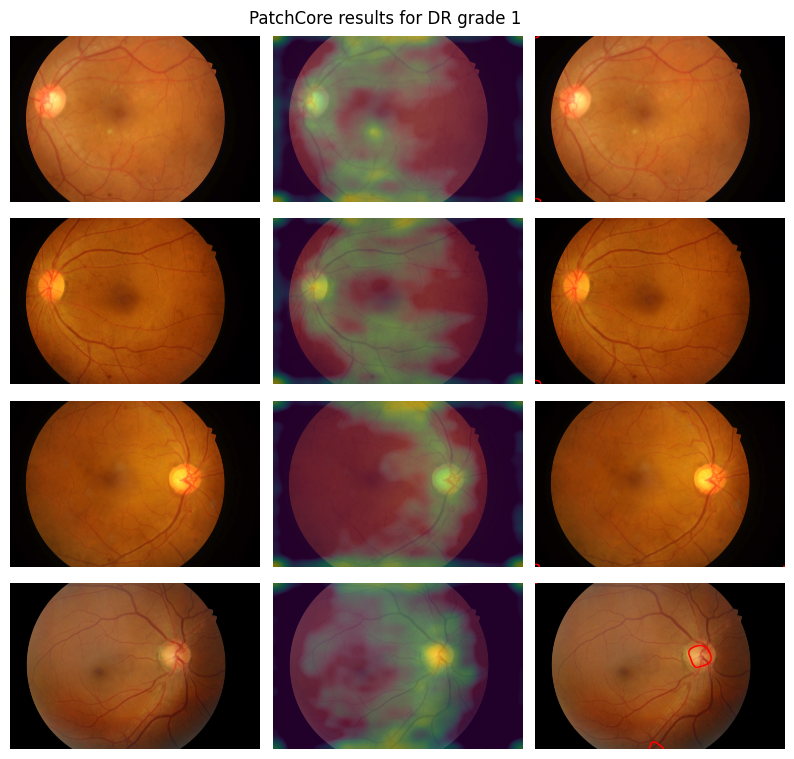

In [ ]:
for grade in range(1, 2):
    grade_results = patchcore_results[grade]

    plt.figure(figsize=(10, 15))
    for img_idx, img_fn in enumerate(grade_results):
        img = cv2.imread(img_fn.as_posix())[:, :, ::-1]  # BGR RGB conversion

        anomaly_map = np.squeeze(grade_results[img_fn][0]["anomaly_maps"].numpy())
        anomaly_map_original_size = cv2.resize(
            anomaly_map, (img.shape[1], img.shape[0])
        )
        segmentation_boundary = add_segmentation_boundary(
            img, anomaly_map_original_size, threshold=0.3
        )

        plt.subplot(len(grade_results), 3, img_idx * 3 + 1)
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(len(grade_results), 3, img_idx * 3 + 2)
        plt.imshow(img)
        plt.imshow(anomaly_map_original_size, alpha=0.5)
        plt.axis("off")

        plt.subplot(len(grade_results), 3, img_idx * 3 + 3)
        plt.imshow(segmentation_boundary)
        plt.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=-0.7)
    plt.suptitle(f"PatchCore results for DR grade {grade}", y=0.75)
    plt.show()